### **Spatio Temporal Window Kriging** for mapping daily Sea Level Anomalies from satellite altimetry along-track data (L3 $\rarr$ L4) 
#### https://github.com/mariejuhl/ST-Window-Kriging/blob/main/ST-Window-Kriging.ipynb

### 1. Import Dependencies

In [2]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import xarray as xr 
from sklearn.preprocessing import StandardScaler
import datetime
import tools
from tools import *

### 2. Input data, Area Selection, Mask and Subsampling

In [ ]:
lat_min ,lat_max, lon_min , lon_max, extra = 32, 42, 360-128,360-116, 1

## input data 
l3 = xr.open_dataset('~/Documents/OK-ST-package/sample_data/L3_CALIFORNIA_2018_all_missions.nc').rename({'sla_unfiltered':'resid'})
l3 = select_data_xarray(l3,lat_min-extra, lat_max+extra, lon_min-extra, lon_max+extra, 2018, 2018).to_dataframe().dropna()

## sample grid used from CMEMS:
grid = xr.open_dataset("~/Documents/OK-ST-package/sample_data/DUACS_GRID_CALIFORNIA_2018.nc")
grid = select_data_xarray(grid,lat_min, lat_max, lon_min-360, lon_max-360, 2018, 2018)

# build land mask from CMEMS grid, own grid can be inlcuded: add mask for land if possible 
# otherwise prediction will be made where 'sla' is given e.g. when supplying CMEMS gridded data as grid 
grid['mask'] = np.invert(np.isnan(grid['sla']))    
grid=grid.to_dataframe().reset_index()
grid['land'] =1
grid['land'][grid['mask'].values==False]=np.nan

## reorganizing and subsampling by 1/5th
l3         = l3[['longitude','latitude','resid','source']].dropna()
l3         = l3[::5] 
l3['time'] = l3.index;
l3

### 3. Producing daily Maps:

Processing time: 2018-05-05 00:00:00
Making temporal matrix...
Making distance matrix...
Making value matrix...
Fitting Results for time 2018-05-05 00:00:00:
  MAE: 0.1126, RMSE: 0.1598, R^2: 0.6048
2018-05-05 00:00:00
Preparing...


  0%|          | 0/1920 [00:00<?, ?it/s]

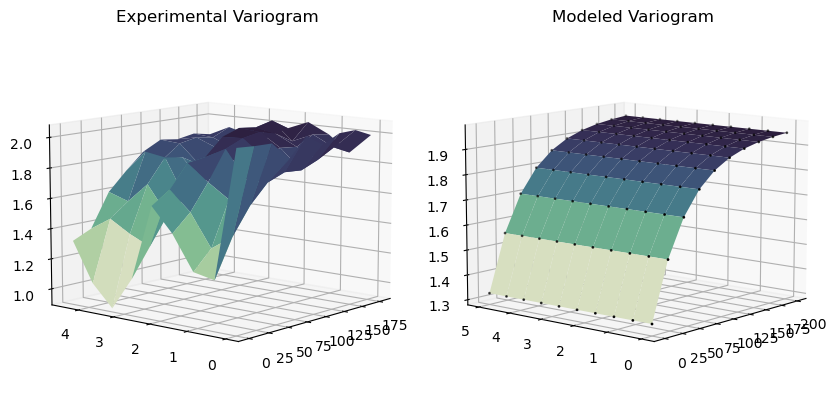

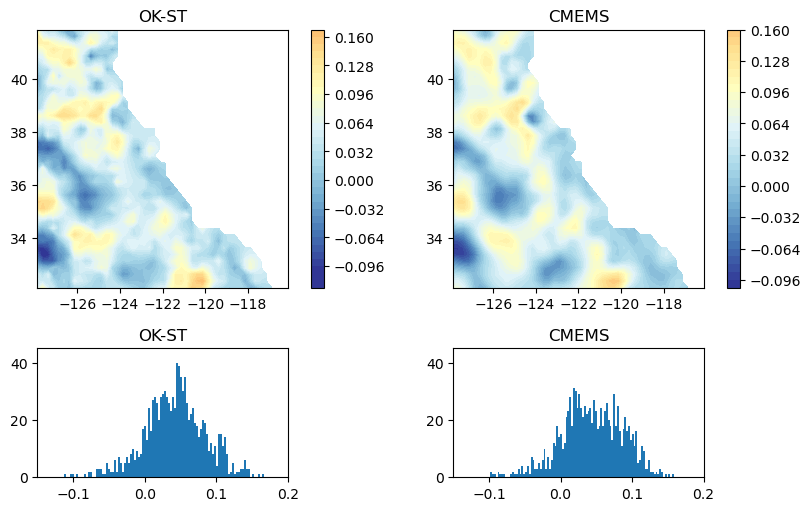

In [ ]:
# Define the time period of Kriging:
start_date = pd.to_datetime(datetime.date(2018,5,5))
end_date   = pd.to_datetime(datetime.date(2018,5,5))
run_time   = pd.date_range(start=start_date, end=end_date)

import importlib
importlib.reload(tools)


'''
Input parameters: 

l3 (DataFrame)      : DataFrame containing residual data with a time index. 'latitude', 'longitude' and 'resid' needs to be given.  
grid (DataFrame)    : Empty Grid provided containing, e.g. CMEMS grid provided with land mask to only predict ocean points
hs/ht range (tuple) : Bins in space and time: Bin number must be the same in space and time !!!     
estimator (str)     : Kind of estimation of the esxperimental variogram in space-time. Choose between 'matheron' or 'cressie'. Default is #matheron'.
func (callable)     : Function of building the space-time variogram model. 'sum-metric' tested and implememted.
plot (bool)         : Whether to plot the experimental and modeled variograms for each day.
exact (bool)        : Controlls smoothness of the prediction. True (default) sets diagonal of the Kriging matrix to zero, smoothing the result, allwing more deviation from the observations. 

Kriging (optional): 

  - if Kriging = False --> function returns 2 parameters (paras and fitting quality)
  - if Kriging = True  --> Function returns dataframe given as grid, added OK-ST and OK-ST-error

Saving Grid (optional):

    a valid path for 'save_as_csv    = /.../...' for save as CSV
    a valid path for 'save_as_netcdf = /.../...' for save as NETCDF '''


for xtime in run_time:
  df = ST_Window_Kriging( xtime                = xtime, 
                                l3             = l3,    
                                grid           = grid,
                                n_days         = 5, 
                                hs_range       = (0,200,10),
                                ht_range       = (0,5,10), 
                                estimator      = 'matheron', 
                                func           = sum_metric_model, 
                                plot           = True, 
                                Kriging        = True,
                                exact          = False, 
                                save_as_csv    = None,
                                save_as_netcdf = None)
  


  # Daily test plot for checking the results is created:
  ds = df.set_index(['time','latitude','longitude']).to_xarray()

  fig,axis = plt.subplot_mosaic("""AB
                                   AB
                                   CD""", figsize=(8,5), layout='constrained',gridspec_kw={'hspace': 0.1, 'wspace': 0.1}, )   

  a1 = axis['A'].contourf(ds.longitude,ds.latitude,ds.OK_ST[0,:,:],levels=40,cmap='RdYlBu_r', vmin=-0.1, vmax=0.3);
  plt.colorbar(a1, ax=axis['A']);axis['A'].set_title('OK-ST');
  a2 = axis['B'].contourf(ds.longitude,ds.latitude,ds.sla[0,:,:],levels = 40,cmap='RdYlBu_r', vmin=-0.1, vmax=0.3);
  plt.colorbar(a2, ax=axis['B']);axis['B'].set_title('CMEMS');

  axis['C'].hist(ds.OK_ST[0,:,:].values.flatten(), bins=100);
  axis['C'].set_title('OK-ST');
  axis['C'].set_ylim(0,45);axis['C'].set_xlim(-0.15,0.2)
  axis['D'].hist(ds.sla[0,:,:].values.flatten(), bins=100);
  axis['D'].set_title('CMEMS');
  axis['D'].set_ylim(0,45);axis['D'].set_xlim(-0.15,0.2)
  plt.show()
